# Predicts the winner! Part 2
---

## Content Overview

- Section 1 - Hyperparameter Tuning 
- Section 2 - Detortion
- Section 3 - Suggestions received from Presentation 

In "Predict the winner! Part 1", we have ran through a round of relentless elimination and came to an agreement that the 4 classifiers (with their default hyperparameter settings) as followed are best fitting with our home-made movie dataset. 

> 1. Random Forest
> 2. Extremely Randomized Trees (Extra Trees)
> 3. Bagging Classifer
> 4. Light Gradient Boosting Machine (LGBM) Classifier

Now in the section 1 of this notebook, we will determine which classifier (***after hyperparameter tuning***) out of the four is the best for our movie dataset. After that in section 2, we will go deeper and hopefully gain some insights about whether manipulating the features input will cause distortion/great imbalance to our prediction models. And finally in section 3, we will adopt the suggestions received from TAs during the presentation on 16 April 2020 to exclude the film awards feature category from our features input and see whether the classifier is still able to correctly predict the actual Oscar winner.


In [1]:
# Basic
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import tree
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

#Classifiers related
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from lightgbm import LGBMClassifier

# For Hyperparameter Tuning
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

plt.style.use("ggplot")
pd.set_option('mode.chained_assignment', None)

In [2]:
data = pd.read_csv('data/movie_dataset_final.csv')
data.head()

,Year,Movie,Oscar_winner,Oscar_nominee,Runtime (min),Certificate,Directors,Actors,Metascore,IMDb_rating,...,Golden_Bear_winner,Golden_Bear_nominee,Golden_Lion_winner,Golden_Lion_nominee,PCA_winner,PCA_nominee,NYFCC_winner,NYFCC_nominee,OFCS_winner,OFCS_nominee
0,1999,Fight Club,0,0,139,R(A),David Fincher,"['Brad Pitt', 'Edward Norton', 'Meat Loaf', 'Z...",66,8.8,...,0,0,0,0,0,0,0,0,0,1
1,1999,The Matrix,0,0,136,PG,Lana Wachowski Lilly Wachowski,"['Keanu Reeves', 'Laurence Fishburne', 'Carrie...",73,8.7,...,0,0,0,0,0,0,0,0,0,0
2,1999,The Green Mile,0,1,189,R(A),Frank Darabont,"['Tom Hanks', 'Michael Clarke Duncan', 'David ...",61,8.6,...,0,0,0,0,0,0,0,0,0,0
3,1999,American Beauty,1,1,122,R(A),Sam Mendes,"['Kevin Spacey', 'Annette Bening', 'Thora Birc...",84,8.3,...,0,0,0,0,1,1,0,1,1,1
4,1999,The Sixth Sense,0,1,107,PG,M. Night Shyamalan,"['Bruce Willis', 'Haley Joel Osment', 'Toni Co...",64,8.1,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Train on 16 years, predict on recent 5 years
train = data[data['Year'] < 2015]
test = data[data['Year'] >= 2015]

In [4]:
train['Oscar_winner'].value_counts()

0    1584
1      16
Name: Oscar_winner, dtype: int64

In [5]:
movie_name = np.array(test["Movie"])
year = np.array(test["Year"])
oscar_w = np.array(test["Oscar_winner"])
oscar_n = np.array(test["Oscar_nominee"])

In [6]:
# by default majority class (benign) will be negative
lb = LabelBinarizer()
data['Oscar_winner'] = lb.fit_transform(data['Oscar_winner'].values)


In [7]:
# feat. = feature
feat_film_elements = ['Runtime (min)', 'Action', 'Adventure', 'Animation', 'Biography', 
                      'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Musical', 'Mystery', 
                      'Romance', 'Sci-Fi', 'Sport','Thriller', 'War', 'Western']  # Genre - binary  #20

feat_movie_critics = ['IMDb_rating', 'IMDb_votes','RT_rating','RT_review','Metascore']  #5

feat_commercial = ['Budget','Domestic (US) gross', 'International gross', 'Worldwide gross'] #4

feat_awards = ['GG_drama_winner', 'GG_drama_nominee', 'GG_comedy_winner', 'GG_comedy_nominee',
               'BAFTA_winner', 'BAFTA_nominee', 'DGA_winner', 'DGA_nominee',
               'PGA_winner', 'PGA_nominee', 'CCMA_winner', 'CCMA_nominee',
               'Golden_Palm_winner', 'Golden_Palm_nominee', 'Golden_Bear_winner', 'Golden_Bear_nominee',
               'Golden_Lion_winner', 'Golden_Lion_nominee', 'PCA_winner', 'PCA_nominee',
               'NYFCC_winner', 'NYFCC_nominee', 'OFCS_winner', 'OFCS_nominee'] #24

all_features = []

all_features = feat_film_elements + feat_movie_critics + feat_commercial + feat_awards

X_train = train[all_features]
X_test = test[all_features]
y_train = train['Oscar_winner']
y_test = test['Oscar_winner']

---
# Section 1 - Hyparameter Tuning

The best way to think about hyperparameters is like the settings of an algorithm that can be adjusted to optimize performance.
Not all model hyperparameters are equally important. Some hyperparameters have an outsized effect on the behavior, and in turn, the performance of a machine learning algorithm.

Most important hyperparameters of a Random Forest Classifier:

### 1. max_depth 
     
The deeper the tree, the more splits it has and it captures more information about the data. Each tree in the random forest model makes multiple splits to isolate homogeneous groups of outcomes. Larger numbers of splits allowed in each tree enables the trees to explain more variation in the data, however, trees with many splits may overfit the data. A range of depth values should be evaluated, including “None” where trees are split until all the leaves are pure.

###  2. max_features

Random forest models randomly resample features prior to determining the best split. Max_features determines the number of features to resample. Larger max_feature values can result in improved model performance because trees have a larger selection of features from which choose the best split, but can also cause trees to be less diverse and induce overfitting. The common theme here is one needs to identify an optimal value that balances overfitting and under-fitting. Common choices include:

- ‘auto’: places no restrictions on the number of features,
- ‘sqrt’: square root of the total number of features,
- ‘log2’: base two logarithm of the total number of features.

    
###  3. min_samples_split

We can control the minimum number of samples required to split each node. Values too large may cause under-fitting, as the trees won’t be able to split enough times to achieve node purity. This hyperparameter should be based on the number of records in the training dataset.

###  4. min_samples_leaf

The minimum number of samples required to be at a leaf node. Much like stopping the growth of trees once a minimum number of samples per split is reached, we can set the minimum number of samples required for each leaf. With values too large, the trees may not be able to split enough to capture sufficient variation in the data. Optimal values for this hyperparameter are dependent on the size of the training set.
    
---
    
These hyperparameters could also be adopted in the tuning process of Extra Trees Classifier due to their similarity in nature for both classifiers. By the way, the 'n_estimators' hyperparameters is not included in the tuning process because it is generally believed that the larger the n_estimators the better (at least there is no concern about overfitting the test data), hence we will just standardize it to be 10000 for every classifier we will be using, fair and just :D

---
## Question: Precision or Recall?

We know that we can't rely on the classification accuracy because it is a joke (In fact, we **SHOULDN'T** depend on the accuracy alone at all times). The purpose of our mini project is to correctly identify the actual Oscar winner， hence we should only focus on the true positive rate...? This is an ideal case of course, but we know it's not realistic. 


### Precision attempts to answer the following question:

    What proportion of positive identifications was actually correct? 
    In our case, what proportion of Oscar winner predicted was actually correct?
           
<img src="img/precision.png" width="200" align="center"/>                 
                 
                 
### Recall attempts to answer the following question:

    What proportion of actual positives was identified correctly?
    In our case, what proportion of actual Oscar winner was identified correctly?
    
<img src="img/recall.png" width="200" align="center"/>  



To fully evaluate the effectiveness of a model, we must examine both precision and recall. Unfortunately, precision and recall are often in contradiction. That is, improving precision typically reduces recall and vice versa. Hence, we will be studying **BOTH** precision and recall score produced from the hyperparameter tuning of the classifiers.

---

## Candidate 1 - Random Forest

<img src="img/random forest.png" width="700" align="center"/>

In [8]:
clf = RandomForestClassifier()

param_grid = {
    'max_depth': [10, 20, 30, 40, 50, 100, None],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf' : [1, 2, 5, 10, 15],   
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [9]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [10]:
grid_search_clf = grid_search_wrapper(refit_score='precision_score')

Best params for precision_score
{'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg       493         2
pos         4         1


In [11]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_accuracy_score', 'mean_test_precision_score', 'mean_test_recall_score', 
         'param_max_depth', 'param_max_features', 'param_min_samples_leaf','param_min_samples_split']].round(6).head()

,mean_test_accuracy_score,mean_test_precision_score,mean_test_recall_score,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split
156,0.996250,0.950000,0.75,30,auto,2,5
152,0.996875,0.916667,0.85,30,auto,1,10
3,0.996250,0.916667,0.80,10,auto,1,15
27,0.996250,0.916667,0.80,10,sqrt,1,10
327,0.996250,0.916667,0.80,50,sqrt,1,10


In [12]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')

Best params for recall_score
{'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       493         2
pos         4         1


In [13]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_recall_score', ascending=False)
results[['mean_test_accuracy_score', 'mean_test_precision_score', 'mean_test_recall_score', 
         'param_max_depth', 'param_max_features', 'param_min_samples_leaf','param_min_samples_split']].round(6).head()

,mean_test_accuracy_score,mean_test_precision_score,mean_test_recall_score,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split
75,0.99625,0.900000,0.8,20,auto,1,2
226,0.99625,0.900000,0.8,40,auto,1,5
77,0.99625,0.916667,0.8,20,auto,1,10
250,0.99625,0.916667,0.8,40,sqrt,1,2
178,0.99625,0.816667,0.8,30,sqrt,1,15


In [14]:
y_scores = grid_search_clf.predict_proba(X_test)[:, 1]
# for classifiers with decision_function, this achieves similar results
# y_scores = classifier.decision_function(X_test)

In [15]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)

In [16]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0, 1.01]);
    plt.xlim([0, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

     pred_neg  pred_pos
neg       482        13
pos         1         4


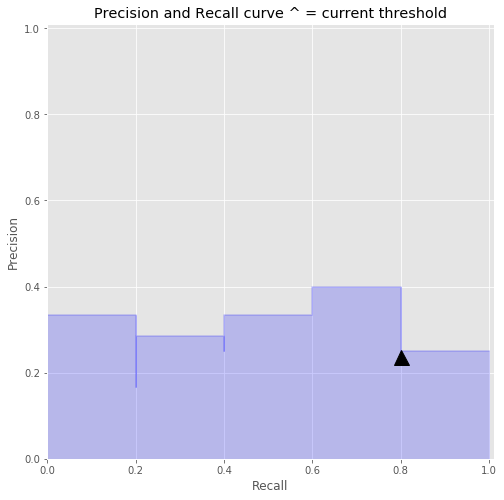

In [17]:
precision_recall_threshold(p, r, thresholds, 0.07)

In [18]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

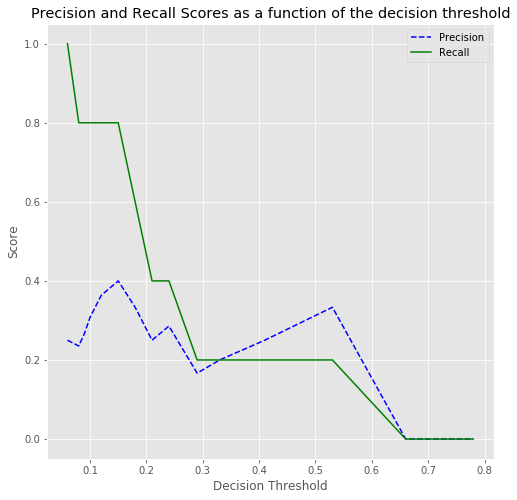

In [19]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)

In [20]:
precision_recall = precision_recall_curve(y_test, y_scores)
precision_recall = pd.DataFrame.from_records(precision_recall).T
precision_recall.columns = ['Precision', 'Recall', 'Thresholds']
precision_recall.iplot(x='Thresholds', xTitle='Decision Threshold',yTitle='Score', title='Precision/Recall Tradeoff')
# Please run this function if you can't view it

In [21]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

0.9866666666666667


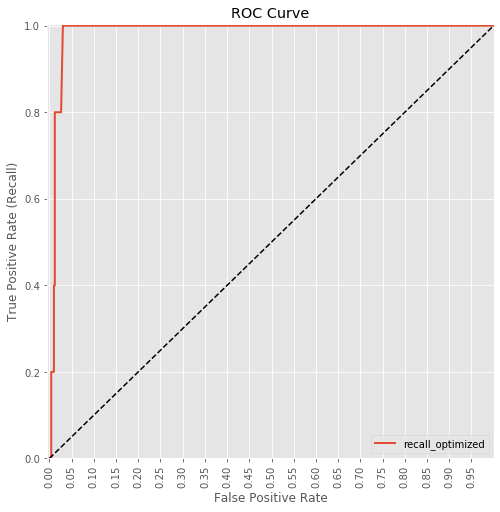

In [22]:
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

By comparing the two tables, to optimise both the precision and recall score, we think the combinations of hyperparameters below are best for Random Forest.

In [24]:
forest = RandomForestClassifier(n_estimators=10000,
                                max_depth=30,
                                max_features = 'auto',
                                min_samples_leaf =1,
                                min_samples_split=10)

my_forest = forest.fit(X_train, y_train)

In [25]:
forest_importances = pd.DataFrame(my_forest.feature_importances_.round(3), all_features, columns=["Importances Weightage"])

print(forest_importances)
print()
print('Score = ', my_forest.score(X_train, y_train))

                     Importances Weightage
Runtime (min)                        0.009
Action                               0.001
Adventure                            0.001
Animation                            0.000
Biography                            0.001
Comedy                               0.001
Crime                                0.005
Drama                                0.001
Family                               0.000
Fantasy                              0.000
History                              0.001
Horror                               0.000
Musical                              0.001
Mystery                              0.000
Romance                              0.001
Sci-Fi                               0.001
Sport                                0.005
Thriller                             0.006
War                                  0.001
Western                              0.000
IMDb_rating                          0.020
IMDb_votes                           0.033
RT_rating  

In [26]:
forest_importances['Features'] = all_features
fig = px.bar(forest_importances, x='Features', y='Importances Weightage', 
             title='Features Importances', height=600)
fig.show()

In [27]:
pred_forest = my_forest.predict_proba(X_test)[:, 1]

forest_prediction = pd.DataFrame(year, columns=["Year"])
forest_prediction["Movie"] = movie_name
forest_prediction["Oscar_nominee"] = oscar_n
forest_prediction["Oscar_winner"] = oscar_w
forest_prediction['Predicted Win Rate'] = pred_forest

forest_prediction.head(5)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
0,2015,Star Wars: Episode VII - The Force Awakens,0,0,0.004067
1,2015,Mad Max: Fury Road,1,0,0.065507
2,2015,The Martian,1,0,0.017947
3,2015,Avengers: Age of Ultron,0,0,0.012387
4,2015,The Revenant,1,0,0.407622


In [28]:
normalized_prediction = forest_prediction.copy()

for index, row in normalized_prediction.iterrows():
    normalized_prediction.loc[index, "Predicted Win Rate"] = \
        (row["Predicted Win Rate"] / forest_prediction["Predicted Win Rate"][forest_prediction["Year"] == row["Year"]].sum()).round(3)

In [29]:
normalized_prediction[normalized_prediction["Year"] == 2015].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
4,2015,The Revenant,1,0,0.374
9,2015,Spotlight,1,1,0.239
14,2015,The Big Short,1,0,0.157
1,2015,Mad Max: Fury Road,1,0,0.060
13,2015,Room,1,0,0.034
56,2015,Carol,0,0,0.020
2,2015,The Martian,1,0,0.016
17,2015,Bridge of Spies,1,0,0.013
3,2015,Avengers: Age of Ultron,0,0,0.011
6,2015,Jurassic World,0,0,0.011


In [30]:
normalized_prediction[normalized_prediction["Year"] == 2016].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
107,2016,La La Land,1,0,0.650
116,2016,Moonlight,1,1,0.095
122,2016,Manchester by the Sea,1,0,0.075
105,2016,Arrival,1,0,0.034
130,2016,Lion,1,0,0.018
131,2016,Ghostbusters,0,0,0.013
109,2016,Hacksaw Ridge,1,0,0.012
106,2016,Rogue One,0,0,0.011
100,2016,Deadpool,0,0,0.010
102,2016,Batman v Superman: Dawn of Justice,0,0,0.010


In [31]:
normalized_prediction[normalized_prediction["Year"] == 2017].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
213,2017,The Shape of Water,1,1,0.458
211,2017,"Three Billboards Outside Ebbing, Missouri",1,0,0.152
230,2017,Call Me by Your Name,1,0,0.062
224,2017,Lady Bird,1,0,0.059
207,2017,Get Out,1,0,0.056
205,2017,Dunkirk,1,0,0.036
236,2017,"I, Tonya",0,0,0.023
246,2017,The Post,1,0,0.018
232,2017,Mother!,0,0,0.015
203,2017,Star Wars: Episode VIII - The Last Jedi,0,0,0.012


In [32]:
normalized_prediction[normalized_prediction["Year"] == 2018].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
330,2018,Roma,1,0,0.281
309,2018,Green Book,1,1,0.194
303,2018,Bohemian Rhapsody,1,0,0.059
321,2018,BlacKkKlansman,1,0,0.059
310,2018,A Star Is Born,1,0,0.057
325,2018,The Favourite,1,0,0.050
344,2018,Vice,1,0,0.050
301,2018,Black Panther,1,0,0.026
326,2018,First Man,0,0,0.017
318,2018,Hereditary,0,0,0.016


In [33]:
normalized_prediction[normalized_prediction["Year"] == 2019].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
408,2019,1917,1,0,0.363
402,2019,Once Upon a Time in Hollywood,1,0,0.196
404,2019,Parasite,1,1,0.107
400,2019,Joker,1,0,0.071
407,2019,The Irishman,1,0,0.052
418,2019,Jojo Rabbit,1,0,0.045
413,2019,Marriage Story,1,0,0.030
442,2019,Little Women,1,0,0.013
415,2019,Us,0,0,0.011
419,2019,The Lion King,0,0,0.011


## Candidate 2 - Extremely Randomized Trees (Extra Trees)

In [34]:
clf = ExtraTreesClassifier()

In [35]:
grid_search_clf = grid_search_wrapper(refit_score='precision_score')

Best params for precision_score
{'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 15}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg       493         2
pos         4         1


In [36]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_accuracy_score', 'mean_test_precision_score', 'mean_test_recall_score', 
         'param_max_depth', 'param_max_features', 'param_min_samples_leaf','param_min_samples_split']].round(6).head()

,mean_test_accuracy_score,mean_test_precision_score,mean_test_recall_score,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split
104,0.99625,0.916667,0.8,20,sqrt,1,20
409,0.99625,0.916667,0.8,100,sqrt,2,20
34,0.99625,0.916667,0.8,10,sqrt,2,20
80,0.99625,0.916667,0.8,20,auto,2,2
8,0.99625,0.916667,0.8,10,auto,2,15


In [37]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')

Best params for recall_score
{'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       493         2
pos         4         1


In [38]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_recall_score', ascending=False)
results[['mean_test_accuracy_score', 'mean_test_precision_score', 'mean_test_recall_score', 
         'param_max_depth', 'param_max_features', 'param_min_samples_leaf','param_min_samples_split']].round(6).head()

,mean_test_accuracy_score,mean_test_precision_score,mean_test_recall_score,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split
453,0.996875,0.916667,0.85,None,auto,1,15
150,0.996875,0.916667,0.85,30,auto,1,2
303,0.996875,0.916667,0.85,50,auto,1,15
454,0.996875,0.916667,0.85,None,auto,1,20
428,0.996250,0.916667,0.80,100,log2,1,15


In [39]:
y_scores = grid_search_clf.predict_proba(X_test)[:, 1]
# for classifiers with decision_function, this achieves similar results
# y_scores = classifier.decision_function(X_test)

In [40]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)

     pred_neg  pred_pos
neg       487         8
pos         1         4


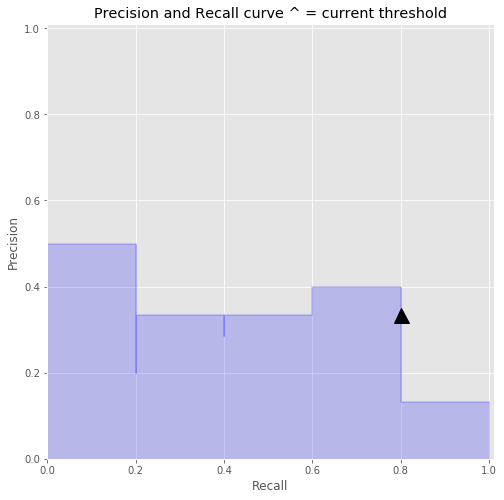

In [41]:
precision_recall_threshold(p, r, thresholds, 0.07)

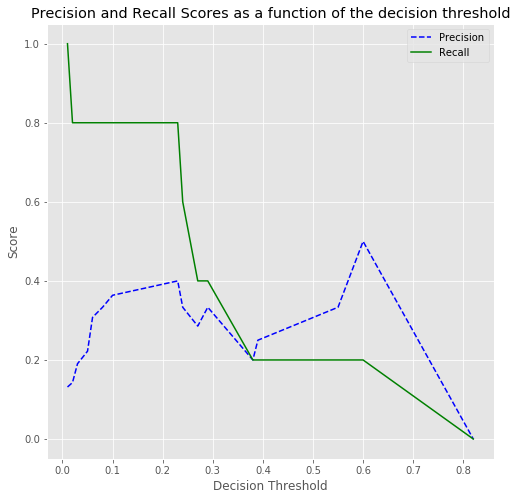

In [42]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)

In [43]:
precision_recall = precision_recall_curve(y_test, y_scores)
precision_recall = pd.DataFrame.from_records(precision_recall).T
precision_recall.columns = ['Precision', 'Recall', 'Thresholds']
precision_recall.iplot(x='Thresholds', xTitle='Decision Threshold',yTitle='Score', title='Precision/Recall Tradeoff')

0.9818181818181818


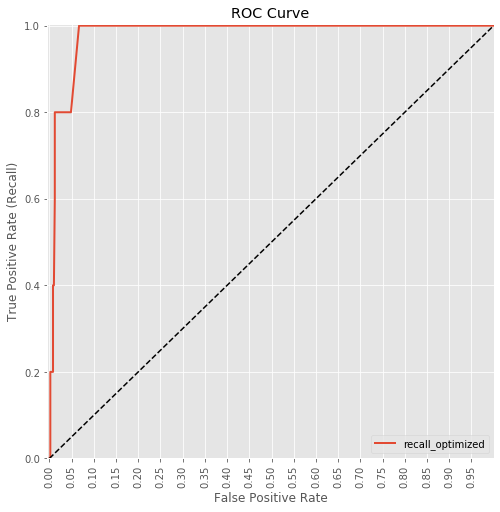

In [44]:
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

To optimise both the precision & recall score, the combinations of hyperparameters below are the best for Extra Trees.

In [123]:
extratree = ExtraTreesClassifier(n_estimators=10000,
                                 max_depth=None,
                                 max_features='auto',
                                 min_samples_leaf=1,
                                 min_samples_split=15)

extree = extratree.fit(X_train, y_train)

In [124]:
extree_importances = pd.DataFrame(extree.feature_importances_.round(3), all_features, columns=["Importances Weightage"])

print(extree_importances)
print()
print('Score = ', extree.score(X_train, y_train))

                     Importances Weightage
Runtime (min)                        0.001
Action                               0.002
Adventure                            0.001
Animation                            0.000
Biography                            0.001
Comedy                               0.002
Crime                                0.005
Drama                                0.001
Family                               0.000
Fantasy                              0.000
History                              0.001
Horror                               0.000
Musical                              0.000
Mystery                              0.000
Romance                              0.001
Sci-Fi                               0.002
Sport                                0.005
Thriller                             0.007
War                                  0.001
Western                              0.000
IMDb_rating                          0.005
IMDb_votes                           0.008
RT_rating  

In [125]:
extree_importances['Features'] = all_features
fig = px.bar(extree_importances, x='Features', y='Importances Weightage', 
             title='Features Importances', height=600)
fig.show()

In [126]:
pred_extree = extree.predict_proba(X_test)[:, 1]

extree_df = pd.DataFrame(year, columns=["Year"])
extree_df["Movie"] = movie_name
extree_df["Oscar_nominee"] = oscar_n
extree_df["Oscar_winner"] = oscar_w
extree_df['Predicted Win Rate'] = pred_extree

extree_df.head(5)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
0,2015,Star Wars: Episode VII - The Force Awakens,0,0,0.000600
1,2015,Mad Max: Fury Road,1,0,0.036361
2,2015,The Martian,1,0,0.011126
3,2015,Avengers: Age of Ultron,0,0,0.000611
4,2015,The Revenant,1,0,0.400081


In [127]:
normalized_prediction = extree_df.copy()

for index, row in normalized_prediction.iterrows():
    normalized_prediction.loc[index, "Predicted Win Rate"] = \
        (row["Predicted Win Rate"] / extree_df["Predicted Win Rate"][extree_df["Year"] == row["Year"]].sum()).round(3)   

In [128]:
normalized_prediction[normalized_prediction["Year"] == 2015].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
4,2015,The Revenant,1,0,0.370
9,2015,Spotlight,1,1,0.304
14,2015,The Big Short,1,0,0.192
1,2015,Mad Max: Fury Road,1,0,0.034
13,2015,Room,1,0,0.030
17,2015,Bridge of Spies,1,0,0.023
56,2015,Carol,0,0,0.015
2,2015,The Martian,1,0,0.010
11,2015,Sicario,0,0,0.010
50,2015,Brooklyn,1,0,0.002


In [129]:
normalized_prediction[normalized_prediction["Year"] == 2016].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
107,2016,La La Land,1,0,0.769
116,2016,Moonlight,1,1,0.094
105,2016,Arrival,1,0,0.045
122,2016,Manchester by the Sea,1,0,0.028
130,2016,Lion,1,0,0.028
133,2016,Hell or High Water,1,0,0.012
109,2016,Hacksaw Ridge,1,0,0.007
100,2016,Deadpool,0,0,0.004
125,2016,Sully,0,0,0.002
124,2016,Nocturnal Animals,0,0,0.001


In [130]:
normalized_prediction[normalized_prediction["Year"] == 2017].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
213,2017,The Shape of Water,1,1,0.619
211,2017,"Three Billboards Outside Ebbing, Missouri",1,0,0.204
207,2017,Get Out,1,0,0.055
224,2017,Lady Bird,1,0,0.038
230,2017,Call Me by Your Name,1,0,0.025
205,2017,Dunkirk,1,0,0.020
236,2017,"I, Tonya",0,0,0.009
246,2017,The Post,1,0,0.006
232,2017,Mother!,0,0,0.004
247,2017,Molly's Game,0,0,0.004


In [131]:
normalized_prediction[normalized_prediction["Year"] == 2018].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
330,2018,Roma,1,0,0.474
309,2018,Green Book,1,1,0.274
321,2018,BlacKkKlansman,1,0,0.057
303,2018,Bohemian Rhapsody,1,0,0.053
325,2018,The Favourite,1,0,0.040
344,2018,Vice,1,0,0.029
310,2018,A Star Is Born,1,0,0.027
301,2018,Black Panther,1,0,0.008
326,2018,First Man,0,0,0.005
350,2018,Creed II,0,0,0.005


In [132]:
normalized_prediction[normalized_prediction["Year"] == 2019].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
408,2019,1917,1,0,0.446
402,2019,Once Upon a Time in Hollywood,1,0,0.251
404,2019,Parasite,1,1,0.101
407,2019,The Irishman,1,0,0.053
400,2019,Joker,1,0,0.050
418,2019,Jojo Rabbit,1,0,0.050
413,2019,Marriage Story,1,0,0.015
425,2019,Uncut Gems,0,0,0.010
409,2019,Knives Out,0,0,0.006
442,2019,Little Women,1,0,0.003


Extra Trees > Random Forest, slightly

## Candidate 3 - Bagging Classifier

We don't really bother to do tuning for Bagging Classifier, we will just change its base estimator from the defualt Decision Tree Classifier to the Extra Trees Classifier with the tuned hyperparameter and see how it works.

In [55]:
BC = BaggingClassifier(ExtraTreesClassifier(n_estimators=10000,
                                            max_depth=None,
                                            max_features='auto',
                                            min_samples_leaf=1,
                                            min_samples_split=15))

my_BC = BC.fit(X_train, y_train)

In [56]:
pred_BC = my_BC.predict_proba(X_test)[:, 1]

BC_prediction = pd.DataFrame(year, columns=["Year"])
BC_prediction["Movie"] = movie_name
BC_prediction["Oscar_nominee"] = oscar_n
BC_prediction["Oscar_winner"] = oscar_w
BC_prediction['Predicted Win Rate'] = pred_BC

BC_prediction.head(5)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
0,2015,Star Wars: Episode VII - The Force Awakens,0,0,0.001054
1,2015,Mad Max: Fury Road,1,0,0.050872
2,2015,The Martian,1,0,0.023220
3,2015,Avengers: Age of Ultron,0,0,0.001095
4,2015,The Revenant,1,0,0.401167


In [57]:
normalized_prediction = BC_prediction.copy()

for index, row in normalized_prediction.iterrows():
    normalized_prediction.loc[index, "Predicted Win Rate"] = \
        (row["Predicted Win Rate"] / BC_prediction["Predicted Win Rate"][BC_prediction["Year"] == row["Year"]].sum()).round(3)

In [58]:
normalized_prediction[normalized_prediction["Year"] == 2015].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
4,2015,The Revenant,1,0,0.341
9,2015,Spotlight,1,1,0.276
14,2015,The Big Short,1,0,0.197
13,2015,Room,1,0,0.047
1,2015,Mad Max: Fury Road,1,0,0.043
17,2015,Bridge of Spies,1,0,0.025
2,2015,The Martian,1,0,0.020
56,2015,Carol,0,0,0.016
11,2015,Sicario,0,0,0.014
21,2015,Creed,0,0,0.003


In [59]:
normalized_prediction[normalized_prediction["Year"] == 2016].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
107,2016,La La Land,1,0,0.669
116,2016,Moonlight,1,1,0.133
105,2016,Arrival,1,0,0.058
130,2016,Lion,1,0,0.047
122,2016,Manchester by the Sea,1,0,0.038
133,2016,Hell or High Water,1,0,0.018
109,2016,Hacksaw Ridge,1,0,0.009
100,2016,Deadpool,0,0,0.007
131,2016,Ghostbusters,0,0,0.003
125,2016,Sully,0,0,0.003


In [60]:
normalized_prediction[normalized_prediction["Year"] == 2017].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
213,2017,The Shape of Water,1,1,0.534
211,2017,"Three Billboards Outside Ebbing, Missouri",1,0,0.224
207,2017,Get Out,1,0,0.068
224,2017,Lady Bird,1,0,0.045
230,2017,Call Me by Your Name,1,0,0.036
205,2017,Dunkirk,1,0,0.027
236,2017,"I, Tonya",0,0,0.019
246,2017,The Post,1,0,0.007
247,2017,Molly's Game,0,0,0.006
238,2017,Darkest Hour,1,0,0.005


In [61]:
normalized_prediction[normalized_prediction["Year"] == 2018].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
330,2018,Roma,1,0,0.398
309,2018,Green Book,1,1,0.285
303,2018,Bohemian Rhapsody,1,0,0.070
321,2018,BlacKkKlansman,1,0,0.063
325,2018,The Favourite,1,0,0.048
344,2018,Vice,1,0,0.038
310,2018,A Star Is Born,1,0,0.037
301,2018,Black Panther,1,0,0.010
334,2018,Crazy Rich Asians,0,0,0.006
326,2018,First Man,0,0,0.006


In [62]:
normalized_prediction[normalized_prediction["Year"] == 2019].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
408,2019,1917,1,0,0.395
402,2019,Once Upon a Time in Hollywood,1,0,0.228
404,2019,Parasite,1,1,0.113
418,2019,Jojo Rabbit,1,0,0.073
400,2019,Joker,1,0,0.058
407,2019,The Irishman,1,0,0.056
413,2019,Marriage Story,1,0,0.026
425,2019,Uncut Gems,0,0,0.012
409,2019,Knives Out,0,0,0.009
419,2019,The Lion King,0,0,0.006


## Candidate 4 - Light Gradient Boosting Machine (LGBM) Classifier

In [133]:
clf = LGBMClassifier()

In [134]:
grid_search_clf = grid_search_wrapper(refit_score='precision_score')

Best params for precision_score
{'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg       494         1
pos         4         1


In [135]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_accuracy_score', 'mean_test_precision_score', 'mean_test_recall_score', 
         'param_max_depth', 'param_max_features', 'param_min_samples_leaf','param_min_samples_split']].round(6).head()

,mean_test_accuracy_score,mean_test_precision_score,mean_test_recall_score,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split
0,0.99125,0.416667,0.35,10,auto,1,2
361,0.99125,0.416667,0.35,50,log2,5,5
359,0.99125,0.416667,0.35,50,log2,2,20
358,0.99125,0.416667,0.35,50,log2,2,15
357,0.99125,0.416667,0.35,50,log2,2,10


In [136]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')

Best params for recall_score
{'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       494         1
pos         4         1


In [137]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_recall_score', ascending=False)
results[['mean_test_accuracy_score', 'mean_test_precision_score', 'mean_test_recall_score', 
         'param_max_depth', 'param_max_features', 'param_min_samples_leaf','param_min_samples_split']].round(6).head()

,mean_test_accuracy_score,mean_test_precision_score,mean_test_recall_score,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split
0,0.99125,0.416667,0.35,10,auto,1,2
361,0.99125,0.416667,0.35,50,log2,5,5
359,0.99125,0.416667,0.35,50,log2,2,20
358,0.99125,0.416667,0.35,50,log2,2,15
357,0.99125,0.416667,0.35,50,log2,2,10


In [138]:
y_scores = grid_search_clf.predict_proba(X_test)[:, 1]
# for classifiers with decision_function, this achieves similar results
# y_scores = classifier.decision_function(X_test)

In [139]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)

     pred_neg  pred_pos
neg       491         4
pos         4         1


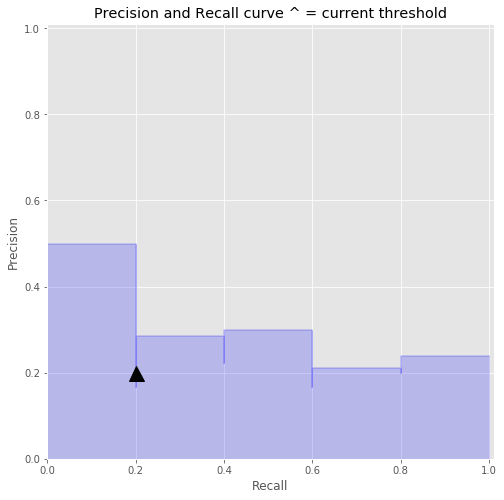

In [140]:
precision_recall_threshold(p, r, thresholds, 0.07)

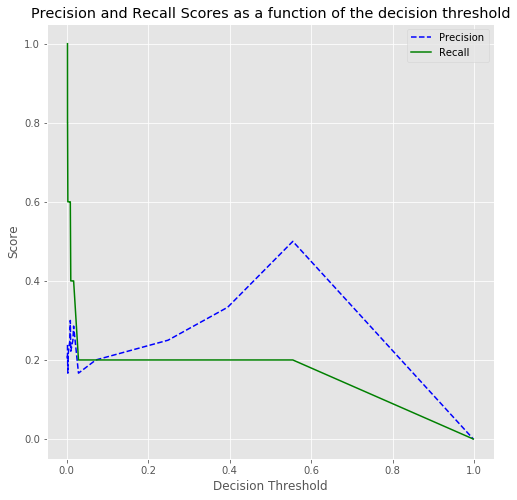

In [141]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)

In [142]:
precision_recall = precision_recall_curve(y_test, y_scores)
precision_recall = pd.DataFrame.from_records(precision_recall).T
precision_recall.columns = ['Precision', 'Recall', 'Thresholds']
precision_recall.iplot(x='Thresholds', xTitle='Decision Threshold',yTitle='Score', title='Precision/Recall Tradeoff')

0.9822222222222222


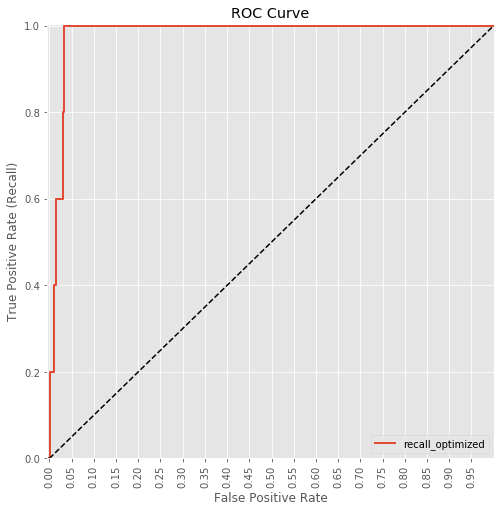

In [143]:
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

Again, to optimise both the precision & recall score, the combinations of hyperparameters below work the best for LGBM.

In [144]:
LGBM = LGBMClassifier(learning_rate=0.000421,  # The learning rate is determined by trial and error
                      max_depth=10,
                      max_featurs='auto',
                      min_samples_leaf=1,
                      min_samples_split=2,
                      n_estimators=10000)

my_LGBM = LGBM.fit(X_train, y_train)

In [145]:
LGBM_importances = pd.DataFrame(my_LGBM.feature_importances_.round(3), all_features, columns=["Importances Weightage"])

print(LGBM_importances)
print()
print('Score = ', my_LGBM.score(X_train, y_train))

                     Importances Weightage
Runtime (min)                        20886
Action                                  58
Adventure                               18
Animation                               12
Biography                             2606
Comedy                                 809
Crime                                   61
Drama                                  100
Family                                   1
Fantasy                               3479
History                               2980
Horror                                   4
Musical                               1735
Mystery                                  2
Romance                               4855
Sci-Fi                                 270
Sport                                 6864
Thriller                               898
War                                    122
Western                                  0
IMDb_rating                          15994
IMDb_votes                           32487
RT_rating  

In [146]:
LGBM_importances['Features'] = all_features
fig = px.bar(LGBM_importances, x='Features', y='Importances Weightage', 
             title='Features Importances', height=600)
fig.show()

In [147]:
pred_LGBM = my_LGBM.predict_proba(X_test)[:, 1]

LGBM_prediction = pd.DataFrame(year, columns=["Year"])
LGBM_prediction["Movie"] = movie_name
LGBM_prediction["Oscar_nominee"] = oscar_n
LGBM_prediction["Oscar_winner"] = oscar_w
LGBM_prediction['Predicted Win Rate'] = pred_LGBM

LGBM_prediction.head(5)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
0,2015,Star Wars: Episode VII - The Force Awakens,0,0,0.000117
1,2015,Mad Max: Fury Road,1,0,0.087334
2,2015,The Martian,1,0,0.009577
3,2015,Avengers: Age of Ultron,0,0,0.000122
4,2015,The Revenant,1,0,0.068859


In [148]:
normalized_prediction = LGBM_prediction.copy()

for index, row in normalized_prediction.iterrows():
    normalized_prediction.loc[index, "Predicted Win Rate"] = \
        (row["Predicted Win Rate"] / LGBM_prediction["Predicted Win Rate"][LGBM_prediction["Year"] == row["Year"]].sum()).round(3)

In [149]:
normalized_prediction[normalized_prediction["Year"] == 2015].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
9,2015,Spotlight,1,1,0.302
1,2015,Mad Max: Fury Road,1,0,0.300
4,2015,The Revenant,1,0,0.236
14,2015,The Big Short,1,0,0.062
2,2015,The Martian,1,0,0.033
11,2015,Sicario,0,0,0.008
36,2015,Straight Outta Compton,0,0,0.002
64,2015,The Good Dinosaur,0,0,0.001
72,2015,Hitman: Agent 47,0,0,0.001
71,2015,Demolition,0,0,0.001


In [150]:
normalized_prediction[normalized_prediction["Year"] == 2016].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
107,2016,La La Land,1,0,0.840
116,2016,Moonlight,1,1,0.072
122,2016,Manchester by the Sea,1,0,0.038
130,2016,Lion,1,0,0.020
105,2016,Arrival,1,0,0.010
100,2016,Deadpool,0,0,0.002
191,2016,Sing Street,0,0,0.001
109,2016,Hacksaw Ridge,1,0,0.001
134,2016,Hidden Figures,1,0,0.001
133,2016,Hell or High Water,1,0,0.001


In [151]:
normalized_prediction[normalized_prediction["Year"] == 2017].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
207,2017,Get Out,1,0,0.540
205,2017,Dunkirk,1,0,0.144
224,2017,Lady Bird,1,0,0.118
211,2017,"Three Billboards Outside Ebbing, Missouri",1,0,0.103
213,2017,The Shape of Water,1,1,0.075
230,2017,Call Me by Your Name,1,0,0.001
236,2017,"I, Tonya",0,0,0.001
267,2017,The Florida Project,0,0,0.000
275,2017,Death Note,0,0,0.000
274,2017,Going in Style,0,0,0.000


In [152]:
normalized_prediction[normalized_prediction["Year"] == 2018].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
309,2018,Green Book,1,1,0.384
310,2018,A Star Is Born,1,0,0.286
330,2018,Roma,1,0,0.133
321,2018,BlacKkKlansman,1,0,0.044
344,2018,Vice,1,0,0.032
304,2018,A Quiet Place,0,0,0.030
325,2018,The Favourite,1,0,0.013
303,2018,Bohemian Rhapsody,1,0,0.011
334,2018,Crazy Rich Asians,0,0,0.005
308,2018,Spider-Man: Into the Spider-Verse,0,0,0.003


In [153]:
normalized_prediction[normalized_prediction["Year"] == 2019].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
404,2019,Parasite,1,1,0.490
408,2019,1917,1,0,0.196
402,2019,Once Upon a Time in Hollywood,1,0,0.194
400,2019,Joker,1,0,0.047
418,2019,Jojo Rabbit,1,0,0.032
407,2019,The Irishman,1,0,0.017
409,2019,Knives Out,0,0,0.004
411,2019,Shazam!,0,0,0.001
442,2019,Little Women,1,0,0.001
415,2019,Us,0,0,0.001


## Comments:

Surprisingly, the Light Gradient Boosting Machine Classifier is able to predict 3 years of Oscar winner correctly, and hence the best prediction model! Random Forest and Bagging Classifier still perform more or less the same as in <<Predict the winner! Part 1>> even with tuning this time. However, we are sad to announce that the Extra Trees (with tuning) actually perform worse than before as in Part 1. We... don't know what happened.  。･ﾟ･(つд`ﾟ)･ﾟ･ 

The only reason we could think of is the fact that every time we run a classifier, it gives us slightly different result. So if we look back the result of Extra Trees in <<Predict the winner! Part 1>> (as attached below), we can actually see in 2015 the predicted winner actually won with just a slightly higher probability than the first runner-up (39.5% > 38.2%). So that could be one of the reasons why Extra Trees actually perform worse in this notebook even after tuning. 

<img src="img\extra trees 2015.png" width="900" align="left"/>


---
# Section 2 - Distortion

We will be examining the following cases using Extra Trees Classifier:

> 1. Input top 3 important individual features (deemed by the classifiers) ONLY
> 2. Input top 2 important feature categories ONLY



## Top 3 Important Individual Features

In [154]:
target = train['Oscar_winner'].values

# Considering only the top 3 important features

feature_names = ['DGA_winner', 'PGA_winner', 'CCMA_winner']  

features = train[feature_names].values
test_features = test[feature_names].values

In [155]:
extratree = ExtraTreesClassifier(n_estimators=10000,
                                 max_depth=None,
                                 max_features='auto',
                                 min_samples_leaf=1,
                                 min_samples_split=15)

extree = extratree.fit(features, target)

In [156]:
extree_importances = pd.DataFrame(extree.feature_importances_.round(3), feature_names, columns=["Importances Weightage"])

print(extree_importances)
print()
print('Score = ', extree.score(features, target))

             Importances Weightage
DGA_winner                   0.403
PGA_winner                   0.291
CCMA_winner                  0.306

Score =  0.9975


In [157]:
extree_importances['Features'] = feature_names
fig = px.bar(extree_importances, x='Features', y='Importances Weightage', 
             title='Features Importances', height=600)
fig.show()

In [158]:
pred_extree = extree.predict_proba(test_features)[:, 1]

extree_df = pd.DataFrame(year, columns=["Year"])
extree_df["Movie"] = movie_name
extree_df["Oscar_nominee"] = oscar_n
extree_df["Oscar_winner"] = oscar_w
extree_df['Predicted Win Rate'] = pred_extree

extree_df.head(5)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
0,2015,Star Wars: Episode VII - The Force Awakens,0,0,0.000635
1,2015,Mad Max: Fury Road,1,0,0.000635
2,2015,The Martian,1,0,0.000635
3,2015,Avengers: Age of Ultron,0,0,0.000635
4,2015,The Revenant,1,0,0.617210


In [159]:
normalized_prediction = extree_df.copy()

for index, row in normalized_prediction.iterrows():
    normalized_prediction.loc[index, "Predicted Win Rate"] = \
        (row["Predicted Win Rate"] / extree_df["Predicted Win Rate"][extree_df["Year"] == row["Year"]].sum()).round(3)

In [160]:
normalized_prediction[normalized_prediction["Year"] == 2015].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
4,2015,The Revenant,1,0,0.519
9,2015,Spotlight,1,1,0.224
14,2015,The Big Short,1,0,0.205
0,2015,Star Wars: Episode VII - The Force Awakens,0,0,0.001
64,2015,The Good Dinosaur,0,0,0.001
74,2015,Concussion,0,0,0.001
73,2015,Hardcore Henry,0,0,0.001
72,2015,Hitman: Agent 47,0,0,0.001
71,2015,Demolition,0,0,0.001
70,2015,Self/less,0,0,0.001


In [161]:
normalized_prediction[normalized_prediction["Year"] == 2016].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
107,2016,La La Land,1,0,0.934
100,2016,Deadpool,0,0,0.001
163,2016,The Founder,0,0,0.001
173,2016,Swiss Army Man,0,0,0.001
172,2016,Gods of Egypt,0,0,0.001
171,2016,Allegiant,0,0,0.001
170,2016,Dag II,0,0,0.001
169,2016,Dirty Grandpa,0,0,0.001
168,2016,Lights Out,0,0,0.001
167,2016,Bad Moms,0,0,0.001


In [162]:
normalized_prediction[normalized_prediction["Year"] == 2017].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
213,2017,The Shape of Water,1,1,0.934
200,2017,Logan,0,0,0.001
273,2017,Reis,0,0,0.001
272,2017,The Death of Stalin,0,0,0.001
271,2017,It Comes at Night,0,0,0.001
270,2017,Gerald's Game,0,0,0.001
269,2017,The Circle,0,0,0.001
268,2017,xXx: Return of Xander Cage,0,0,0.001
267,2017,The Florida Project,0,0,0.001
266,2017,Fifty Shades Darker,0,0,0.001


In [163]:
normalized_prediction[normalized_prediction["Year"] == 2018].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
330,2018,Roma,1,0,0.669
309,2018,Green Book,1,1,0.264
300,2018,Avengers: Infinity War,0,0,0.001
364,2018,The Spy Who Dumped Me,0,0,0.001
373,2018,Enes Batur Hayal mi Gerçek mi?,0,0,0.001
372,2018,Eighth Grade,0,0,0.001
371,2018,Mandy,0,0,0.001
370,2018,Johnny English Strikes Again,0,0,0.001
369,2018,Robin Hood,0,0,0.001
368,2018,Death Wish,0,0,0.001


In [164]:
normalized_prediction[normalized_prediction["Year"] == 2019].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
408,2019,1917,1,0,0.643
402,2019,Once Upon a Time in Hollywood,1,0,0.290
400,2019,Joker,1,0,0.001
463,2019,Gemini Man,0,0,0.001
473,2019,The Lego Movie 2: The Second Part,0,0,0.001
472,2019,Happy Death Day 2U,0,0,0.001
471,2019,Velvet Buzzsaw,0,0,0.001
470,2019,Cold Pursuit,0,0,0.001
469,2019,Crawl,0,0,0.001
468,2019,Bombshell,0,0,0.001


bias

## Top 2 Important Feature Categories

In [165]:
# feat. = feature
feat_movie_critics = ['IMDb_rating', 'IMDb_votes','RT_rating','RT_review','Metascore']  #5

feat_awards = ['GG_drama_winner', 'GG_drama_nominee', 'GG_comedy_winner', 'GG_comedy_nominee',
               'BAFTA_winner', 'BAFTA_nominee', 'DGA_winner', 'DGA_nominee',
               'PGA_winner', 'PGA_nominee', 'CCMA_winner', 'CCMA_nominee',
               'Golden_Palm_winner', 'Golden_Palm_nominee', 'Golden_Bear_winner', 'Golden_Bear_nominee',
               'Golden_Lion_winner', 'Golden_Lion_nominee', 'PCA_winner', 'PCA_nominee',
               'NYFCC_winner', 'NYFCC_nominee', 'OFCS_winner', 'OFCS_nominee'] #24

top_2 = []

top_2 = feat_movie_critics + feat_awards

features = train[top_2]
test_features = test[top_2]
target = train['Oscar_winner']

In [166]:
extratree = ExtraTreesClassifier(n_estimators=10000,
                                 max_depth=None,
                                 max_features='auto',
                                 min_samples_leaf=1,
                                 min_samples_split=15)

extree = extratree.fit(features, target)

In [167]:
extree_importances = pd.DataFrame(extree.feature_importances_.round(3), top_2, columns=["Importances Weightage"])

print(extree_importances)
print()
print('Score = ', extree.score(features, target))

                     Importances Weightage
IMDb_rating                          0.006
IMDb_votes                           0.007
RT_rating                            0.004
RT_review                            0.004
Metascore                            0.005
GG_drama_winner                      0.032
GG_drama_nominee                     0.009
GG_comedy_winner                     0.001
GG_comedy_nominee                    0.001
BAFTA_winner                         0.079
BAFTA_nominee                        0.027
DGA_winner                           0.318
DGA_nominee                          0.037
PGA_winner                           0.170
PGA_nominee                          0.016
CCMA_winner                          0.205
CCMA_nominee                         0.005
Golden_Palm_winner                   0.000
Golden_Palm_nominee                  0.001
Golden_Bear_winner                   0.000
Golden_Bear_nominee                  0.001
Golden_Lion_winner                   0.004
Golden_Lion

In [168]:
extree_importances['Features'] = top_2
fig = px.bar(extree_importances, x='Features', y='Importances Weightage', 
             title='Features Importances', height=600)
fig.show()

In [169]:
pred_extree = extree.predict_proba(test_features)[:, 1]

extree_df = pd.DataFrame(year, columns=["Year"])
extree_df["Movie"] = movie_name
extree_df["Oscar_nominee"] = oscar_n
extree_df["Oscar_winner"] = oscar_w
extree_df['Predicted Win Rate'] = pred_extree

extree_df.head(5)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
0,2015,Star Wars: Episode VII - The Force Awakens,0,0,0.000101
1,2015,Mad Max: Fury Road,1,0,0.034564
2,2015,The Martian,1,0,0.015000
3,2015,Avengers: Age of Ultron,0,0,0.000430
4,2015,The Revenant,1,0,0.477339


In [170]:
normalized_prediction = extree_df.copy()

for index, row in normalized_prediction.iterrows():
    normalized_prediction.loc[index, "Predicted Win Rate"] = \
        (row["Predicted Win Rate"] / extree_df["Predicted Win Rate"][extree_df["Year"] == row["Year"]].sum()).round(3)

In [171]:
normalized_prediction[normalized_prediction["Year"] == 2015].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
4,2015,The Revenant,1,0,0.426
9,2015,Spotlight,1,1,0.299
14,2015,The Big Short,1,0,0.186
1,2015,Mad Max: Fury Road,1,0,0.031
13,2015,Room,1,0,0.018
2,2015,The Martian,1,0,0.013
56,2015,Carol,0,0,0.012
17,2015,Bridge of Spies,1,0,0.008
11,2015,Sicario,0,0,0.002
50,2015,Brooklyn,1,0,0.002


In [172]:
normalized_prediction[normalized_prediction["Year"] == 2016].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
107,2016,La La Land,1,0,0.770
116,2016,Moonlight,1,1,0.080
105,2016,Arrival,1,0,0.075
122,2016,Manchester by the Sea,1,0,0.032
130,2016,Lion,1,0,0.025
109,2016,Hacksaw Ridge,1,0,0.005
100,2016,Deadpool,0,0,0.004
133,2016,Hell or High Water,1,0,0.003
125,2016,Sully,0,0,0.001
131,2016,Ghostbusters,0,0,0.001


In [173]:
normalized_prediction[normalized_prediction["Year"] == 2017].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
213,2017,The Shape of Water,1,1,0.677
211,2017,"Three Billboards Outside Ebbing, Missouri",1,0,0.189
224,2017,Lady Bird,1,0,0.034
207,2017,Get Out,1,0,0.029
230,2017,Call Me by Your Name,1,0,0.024
205,2017,Dunkirk,1,0,0.023
236,2017,"I, Tonya",0,0,0.005
238,2017,Darkest Hour,1,0,0.004
232,2017,Mother!,0,0,0.004
246,2017,The Post,1,0,0.004


In [174]:
normalized_prediction[normalized_prediction["Year"] == 2018].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
330,2018,Roma,1,0,0.504
309,2018,Green Book,1,1,0.279
303,2018,Bohemian Rhapsody,1,0,0.044
325,2018,The Favourite,1,0,0.039
344,2018,Vice,1,0,0.037
310,2018,A Star Is Born,1,0,0.037
321,2018,BlacKkKlansman,1,0,0.032
301,2018,Black Panther,1,0,0.008
377,2018,Suspiria,0,0,0.005
361,2018,Mary Poppins Returns,0,0,0.003


In [175]:
normalized_prediction[normalized_prediction["Year"] == 2019].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
408,2019,1917,1,0,0.490
402,2019,Once Upon a Time in Hollywood,1,0,0.291
404,2019,Parasite,1,1,0.077
418,2019,Jojo Rabbit,1,0,0.057
407,2019,The Irishman,1,0,0.038
400,2019,Joker,1,0,0.024
413,2019,Marriage Story,1,0,0.012
442,2019,Little Women,1,0,0.004
419,2019,The Lion King,0,0,0.001
415,2019,Us,0,0,0.001


### Comments: 

### Case 1 - Top 3 Important Individual Features

As we can obviously note, if we only consider the top 3 most important individual features (Director Guild Awards winner, Producer Guild Award winner & Critics' Choice Movie Awards winner) in the input of our models, the results are greatly distorted and bias. The reasoning is fairly simple, movies that didn't win any of the three aforementioned prestigious international film awards will be deemed as "losers" by the prediction models. On the other hand, movies that had won either the DGA, PGA or CCMA such as the La La Land (93.4%) in 2016, The Shape of Water (93.4%) in 2017,  and the 1917 (64.3%) in 2019, are all predicted as winner by the algorithm. We need to be careful of what features to be input into our algorithm to prevent distortion to the model. This reminds us the GIGO concept in computer science: Garbage in, Garbage Out. (。-`ω´-) 

### Case 2 - Top 2 Important Feature Categories

Although the distortion/biasness is not as serious as case 1, but we can still see the 3 DGA, PGA and CCMA almost monopolized the feature importance weightage in the algorithm. Thus, the biasness is still there, but not as much. A simple proof is to note that the predicted winner in each year for both cases is exactly the same, just that in case 2 the winner wins with a slightly lower probability as compared to case 1.  

---
In short, These two cases justified our decision to input ALL 53 features we have into the algorithm every time we do experiment and/or comparison of models. We need to include as much features as possible to sort off **cancel out** the strong influences of the DGA_winner, PGA_winner and CCMA_winner in our algorithm. ╮(╯_╰)╭

---

# Section 3 - Suggestions received during Presentation 

(updated on 20 April 2020)

During our mini project presentation on 16 April 2020, one of the TAs suggested us to try to not include the Film Award feature category in the input feature and see if we are able to predict the Oscar winner correctly with our models. We thought that this was a great idea and hence why not? Hence this section is made particularly for the experiment: to be selective with the input features. (੭•̀ω•́)੭ ̸*✩⁺˚

We will be using only the Random Forest and Extra Trees model for experiment.


## Removal of 'Film Award' feature category from the Input
---

### Random Forest

In [255]:
features_no_awards = []

features_no_awards = feat_film_elements + feat_movie_critics + feat_commercial

features = train[features_no_awards]
test_features = test[features_no_awards]
target = train['Oscar_winner']

In [256]:
forest = RandomForestClassifier(n_estimators=10000,
                                max_depth=30,
                                max_features = 'auto',
                                min_samples_leaf =1,
                                min_samples_split=10)

my_forest_new = forest.fit(features, target)

In [257]:
forest_importances = pd.DataFrame(my_forest_new.feature_importances_.round(3), features_no_awards, columns=["Importances Weightage"])

print(forest_importances)
print()
print('Score = ', my_forest_new.score(features, target))

                     Importances Weightage
Runtime (min)                        0.051
Action                               0.003
Adventure                            0.010
Animation                            0.001
Biography                            0.017
Comedy                               0.003
Crime                                0.012
Drama                                0.019
Family                               0.000
Fantasy                              0.001
History                              0.018
Horror                               0.000
Musical                              0.013
Mystery                              0.001
Romance                              0.006
Sci-Fi                               0.001
Sport                                0.014
Thriller                             0.016
War                                  0.010
Western                              0.000
IMDb_rating                          0.075
IMDb_votes                           0.144
RT_rating  

In [258]:
forest_importances['Features'] = features_no_awards
fig = px.bar(forest_importances, x='Features', y='Importances Weightage', 
             title='Features Importances', height=600)
fig.show()

In [259]:
pred_forest = my_forest_new.predict_proba(test_features)[:, 1]

forest_prediction_new = pd.DataFrame(year, columns=["Year"])
forest_prediction_new["Movie"] = movie_name
forest_prediction_new["Oscar_nominee"] = oscar_n
forest_prediction_new["Oscar_winner"] = oscar_w
forest_prediction_new['Predicted Win Rate'] = pred_forest

forest_prediction_new.head(5)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
0,2015,Star Wars: Episode VII - The Force Awakens,0,0,0.048477
1,2015,Mad Max: Fury Road,1,0,0.139747
2,2015,The Martian,1,0,0.024581
3,2015,Avengers: Age of Ultron,0,0,0.069429
4,2015,The Revenant,1,0,0.081129


In [260]:
normalized_prediction = forest_prediction_new.copy()

for index, row in normalized_prediction.iterrows():
    normalized_prediction.loc[index, "Predicted Win Rate"] = \
        (row["Predicted Win Rate"] / forest_prediction_new["Predicted Win Rate"][forest_prediction_new["Year"] == row["Year"]].sum()).round(3)

In [261]:
normalized_prediction[normalized_prediction["Year"] == 2015].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
1,2015,Mad Max: Fury Road,1,0,0.103
5,2015,Inside Out,0,0,0.070
9,2015,Spotlight,1,1,0.067
4,2015,The Revenant,1,0,0.060
8,2015,The Hateful Eight,0,0,0.054
3,2015,Avengers: Age of Ultron,0,0,0.051
45,2015,Pitch Perfect 2,0,0,0.047
10,2015,Spectre,0,0,0.045
6,2015,Jurassic World,0,0,0.044
0,2015,Star Wars: Episode VII - The Force Awakens,0,0,0.036


In [262]:
normalized_prediction[normalized_prediction["Year"] == 2016].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
107,2016,La La Land,1,0,0.191
122,2016,Manchester by the Sea,1,0,0.129
131,2016,Ghostbusters,0,0,0.042
116,2016,Moonlight,1,1,0.039
150,2016,Dangal,0,0,0.035
142,2016,Kimi no na wa.,0,0,0.034
104,2016,Doctor Strange,0,0,0.034
106,2016,Rogue One,0,0,0.034
102,2016,Batman v Superman: Dawn of Justice,0,0,0.032
103,2016,Suicide Squad,0,0,0.032


In [263]:
normalized_prediction[normalized_prediction["Year"] == 2017].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
230,2017,Call Me by Your Name,1,0,0.083
224,2017,Lady Bird,1,0,0.064
203,2017,Star Wars: Episode VIII - The Last Jedi,0,0,0.061
257,2017,Phantom Thread,1,0,0.050
246,2017,The Post,1,0,0.047
236,2017,"I, Tonya",0,0,0.045
205,2017,Dunkirk,1,0,0.044
217,2017,Beauty and the Beast,1,0,0.043
207,2017,Get Out,1,0,0.042
211,2017,"Three Billboards Outside Ebbing, Missouri",1,0,0.038


In [264]:
normalized_prediction[normalized_prediction["Year"] == 2018].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
310,2018,A Star Is Born,1,0,0.073
325,2018,The Favourite,1,0,0.064
308,2018,Spider-Man: Into the Spider-Verse,0,0,0.052
318,2018,Hereditary,0,0,0.050
321,2018,BlacKkKlansman,1,0,0.047
356,2018,Widows,0,0,0.042
309,2018,Green Book,1,1,0.042
303,2018,Bohemian Rhapsody,1,0,0.041
301,2018,Black Panther,1,0,0.039
326,2018,First Man,0,0,0.038


In [265]:
normalized_prediction[normalized_prediction["Year"] == 2019].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
404,2019,Parasite,1,1,0.137
400,2019,Joker,1,0,0.058
442,2019,Little Women,1,0,0.055
413,2019,Marriage Story,1,0,0.054
402,2019,Once Upon a Time in Hollywood,1,0,0.049
407,2019,The Irishman,1,0,0.043
415,2019,Us,0,0,0.042
408,2019,1917,1,0,0.041
417,2019,Glass,0,0,0.033
401,2019,Avengers: Endgame,0,0,0.031


### Extra Trees

In [266]:
extratree = ExtraTreesClassifier(n_estimators=10000,
                                 max_depth=None,
                                 max_features='auto',
                                 min_samples_leaf=1,
                                 min_samples_split=15)

extree = extratree.fit(features, target)

In [267]:
extree_importances = pd.DataFrame(extree.feature_importances_.round(3), features_no_awards, columns=["Importances Weightage"])

print(extree_importances)
print()
print('Score = ', extree.score(features, target))

                     Importances Weightage
Runtime (min)                        0.029
Action                               0.013
Adventure                            0.012
Animation                            0.002
Biography                            0.026
Comedy                               0.011
Crime                                0.024
Drama                                0.040
Family                               0.001
Fantasy                              0.003
History                              0.031
Horror                               0.000
Musical                              0.034
Mystery                              0.006
Romance                              0.009
Sci-Fi                               0.006
Sport                                0.035
Thriller                             0.037
War                                  0.031
Western                              0.000
IMDb_rating                          0.068
IMDb_votes                           0.186
RT_rating  

In [268]:
extree_importances['Features'] = features_no_awards
fig = px.bar(extree_importances, x='Features', y='Importances Weightage', 
             title='Features Importances', height=600)
fig.show()

In [269]:
pred_extree = extree.predict_proba(test_features)[:, 1]

extree_df = pd.DataFrame(year, columns=["Year"])
extree_df["Movie"] = movie_name
extree_df["Oscar_nominee"] = oscar_n
extree_df["Oscar_winner"] = oscar_w
extree_df['Predicted Win Rate'] = pred_extree

extree_df.head(5)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
0,2015,Star Wars: Episode VII - The Force Awakens,0,0,0.008454
1,2015,Mad Max: Fury Road,1,0,0.015033
2,2015,The Martian,1,0,0.063826
3,2015,Avengers: Age of Ultron,0,0,0.010234
4,2015,The Revenant,1,0,0.060957


In [270]:
normalized_prediction = extree_df.copy()

for index, row in normalized_prediction.iterrows():
    normalized_prediction.loc[index, "Predicted Win Rate"] = \
        (row["Predicted Win Rate"] / extree_df["Predicted Win Rate"][extree_df["Year"] == row["Year"]].sum()).round(3)

In [271]:
normalized_prediction[normalized_prediction["Year"] == 2015].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
82,2015,Eye in the Sky,0,0,0.098
21,2015,Creed,0,0,0.080
8,2015,The Hateful Eight,0,0,0.069
2,2015,The Martian,1,0,0.054
36,2015,Straight Outta Compton,0,0,0.054
4,2015,The Revenant,1,0,0.051
45,2015,Pitch Perfect 2,0,0,0.048
9,2015,Spotlight,1,1,0.046
13,2015,Room,1,0,0.043
33,2015,The Witch: A New-England Folktale,0,0,0.042


In [272]:
normalized_prediction[normalized_prediction["Year"] == 2016].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
107,2016,La La Land,1,0,0.169
122,2016,Manchester by the Sea,1,0,0.106
109,2016,Hacksaw Ridge,1,0,0.087
125,2016,Sully,0,0,0.073
134,2016,Hidden Figures,1,0,0.052
105,2016,Arrival,1,0,0.044
177,2016,Ah-ga-ssi,0,0,0.039
117,2016,The Jungle Book,0,0,0.035
150,2016,Dangal,0,0,0.030
142,2016,Kimi no na wa.,0,0,0.030


In [273]:
normalized_prediction[normalized_prediction["Year"] == 2017].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
230,2017,Call Me by Your Name,1,0,0.082
246,2017,The Post,1,0,0.080
224,2017,Lady Bird,1,0,0.080
236,2017,"I, Tonya",0,0,0.074
205,2017,Dunkirk,1,0,0.070
257,2017,Phantom Thread,1,0,0.062
211,2017,"Three Billboards Outside Ebbing, Missouri",1,0,0.040
232,2017,Mother!,0,0,0.037
217,2017,Beauty and the Beast,1,0,0.034
200,2017,Logan,0,0,0.032


In [274]:
normalized_prediction[normalized_prediction["Year"] == 2018].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
310,2018,A Star Is Born,1,0,0.087
325,2018,The Favourite,1,0,0.084
309,2018,Green Book,1,1,0.065
321,2018,BlacKkKlansman,1,0,0.065
303,2018,Bohemian Rhapsody,1,0,0.062
326,2018,First Man,0,0,0.058
356,2018,Widows,0,0,0.057
318,2018,Hereditary,0,0,0.051
334,2018,Crazy Rich Asians,0,0,0.048
350,2018,Creed II,0,0,0.039


In [275]:
normalized_prediction[normalized_prediction["Year"] == 2019].sort_values("Predicted Win Rate", ascending=False).head(10)

,Year,Movie,Oscar_nominee,Oscar_winner,Predicted Win Rate
404,2019,Parasite,1,1,0.121
400,2019,Joker,1,0,0.086
402,2019,Once Upon a Time in Hollywood,1,0,0.085
408,2019,1917,1,0,0.074
413,2019,Marriage Story,1,0,0.065
401,2019,Avengers: Endgame,0,0,0.052
442,2019,Little Women,1,0,0.042
409,2019,Knives Out,0,0,0.037
407,2019,The Irishman,1,0,0.037
419,2019,The Lion King,0,0,0.028


### Comments:

Not surprising, it's obvious to see that both Random Forest and Extra Trees perform worse than before when the film award feature category is removed from the input. Film Awards are strong features that we scraped and attached to the movie dataset. After all, it is sensible to think that if a movie is able to prove itself to be a good movie by winning a lot of other film awards beside Oscar, that movie is more likely to win the Oscar too, right? Still, although both models are able to predict the 2019 Oscar winner Parasite correctly, the overall performance of the models, by looking at the probabilities as a whole, regressed. It is sad to conclude that our prediction models may not perform too well without the inclusion of film awards feature category in the input.

---
# Conclusion 

Tuned Random Forest and Bagging Classifier (with base estimator Extra Trees Classifier) perform more or less similar to the one with default hyperparameter setting as in <<Predict the winner! Part 1>>. For unknown reasons, the tuned Extremely Randomized Trees classifier perform worse (from able to predict two Oscar winners to only one) in this notebook. The surprising candidate is the tuned Light Gradient Boosting Machine (LGBM) Classifier, the one and only one who can predict **THREE** Oscar winners correctly in this notebook!! o(*≧▽≦)ツ

The influences of the features DGA_winner, PGA_winner & CCMA_winner on the algorithm are too strong. We need to include all features we have in our dataset into the models to balance out the feature importance weightage in the computation of the algorithm.

Without the inclusion of film award feature category, the performance of our model drops, a sad thing to note. (｡ŏ_ŏ)